[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_dec_2023/blob/master/notebooks/Section1_3-Pymc_and_Pytensor.ipynb)

# PyMC and PyTensor

Before we dive into building Bayesian models in PyMC, we want to give a brief introduction to the PyTensor library. PyTensor is a Python library that allows you to define, optimize/rewrite, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. It serves as the computational backend of PyMC.

![pytensor logo](images/PyTensor_RGB.png)

Some of PyTensor’s features are:

- Tight integration with NumPy - Use `numpy.ndarray` in PyTensor-compiled functions
- Efficient symbolic differentiation - PyTensor efficiently computes your derivatives for functions with one or many inputs
- Speed and stability optimizations - Get the right answer for log(1 + x) even when x is near zero
- Dynamic C/JAX/Numba code generation - Evaluate expressions faster

PyTensor is based on Theano, which has been powering large-scale computationally intensive scientific investigations since 2007.

In this notebook we want to give an introduction of how PyMC models translate to PyTensor graphs. The purpose is not to give a detailed description of all [`pytensor`](https://github.com/pytensor-devs/pytensor)'s capabilities but rather focus on the main concepts to understand its connection with PyMC. For a more detailed description of the project please refer to the official documentation.

In [1]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

RANDOM_SEED = 20090425

### A simple example

To begin, we define some pytensor tensors and show how to perform some basic operations.

In [2]:
x = pt.scalar(name="x")
y = pt.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: Scalar(float64, shape=())
x name = x
---
y type: Vector(float64, shape=(?,))
y name = y



Now that we have defined the `x` and `y` tensors, we can create a new one by adding them together.

In [3]:
z = x + y
z.name = "x + y"

To make the computation a bit more complex let us take the logarithm of the resulting tensor.

In [4]:
w = pt.log(z)
w.name = "log(x + y)"

We can use the `pytensor.dprint` function to print the computational graph of any given tensor.

In [5]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


Note that this graph does not do any computation (yet!). It is simply defining the sequence of steps to be done. We can use `pytensor.function` to define a callable object so that we can push values trough the graph.

In [6]:
f = pytensor.function(inputs=[x, y], outputs=w)

Now that the graph is compiled, we can push some concrete values:

In [7]:
f(x=0, y=[1, np.e])

array([0., 1.])

> TIP:
> Sometimes we just want to debug, we can use `pytensor.graph.basic.Variable.eval` for that:

In [8]:
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

You can set intermediate values as well

In [9]:
w.eval({z: [1, np.e]})

array([0., 1.])

### PyTensor is clever!

One of the most important features of `pytensor` is that it can automatically optimize the mathematical operations inside a graph. Let's consider a simple example:

In [10]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

True_div [id A] 'a / b'
 ├─ a [id B]
 └─ b [id C]


Now let us multiply `b` times `c`. This should result in simply `a`.

In [11]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Mul [id A] 'b * c'
 ├─ b [id B]
 └─ True_div [id C] 'a / b'
    ├─ a [id D]
    └─ b [id B]


The graph shows the full computation, but once we compile it the operation becomes the identity on `a` as expected.

In [12]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

DeepCopyOp [id A] 0
 └─ a [id B]


### What is in an PyTensor graph?

The following diagram shows the basic structure of an `pytensor` graph.

![pytensor graph](images/apply.png)

We can can make these concepts more tangible by explicitly indicating them in the first example from the section above. Let us compute the graph components for the tensor `z`. 

In [13]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: Vector(float64, shape=(?,))
z name = x + y
z owner = Add(ExpandDims{axis=0}.0, y)
z owner inputs = [ExpandDims{axis=0}.0, y]
z owner op = Add
z owner output = [x + y]



The following code snippet helps us understand these concepts by going through the computational graph of `w`. The actual code is not as important here, the focus is on the outputs.

In [14]:
# start from the top
stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type Vector(float64, shape=(?,))
 > Op is Log
 > Input 0 is x + y
---
Checking variable x + y of type Vector(float64, shape=(?,))
 > Op is Add
 > Input 0 is ExpandDims{axis=0}.0
 > Input 1 is y
---
Checking variable ExpandDims{axis=0}.0 of type Vector(float64, shape=(1,))
 > Op is ExpandDims{axis=0}
 > Input 0 is x
---
Checking variable y of type Vector(float64, shape=(?,))
 > y is a root variable
---
Checking variable x of type Scalar(float64, shape=())
 > x is a root variable


Note that this is very similar to the output of `pytensor.dprint` function introduced above.

In [15]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


### Exercise: Create and manipulate PyTensor objects

To give you some practice with basic PyTensor data structures and functions, try making the operations below work by implementing the functions that are needed.

In [16]:
import numpy as np

def make_vector():
    """
    Create and return a new Aesara vector.
    """

    pass

def make_matrix():
    """
    Create and return a new Aesara matrix.
    """

    pass

def elemwise_mul(a, b):
    """
    a: An PyTensor matrix
    b: An PyTensor matrix
    
    Calcuate the elementwise product of a and b and return it
    """

    pass

def matrix_vector_mul(a, b):
    """
    a: An PyTensor matrix
    b: An PyTensor vector
    
    Calculate the matrix-vector product of a and b and return it
    """

    pass

a = make_vector()
b = make_vector()
c = elemwise_mul(a, b)
d = make_matrix()
e = matrix_vector_mul(d, c)

f = pytensor.function([a, b, d], e)

rng = np.random.RandomState([1, 2, 3])
a_value = rng.randn(5).astype(a.dtype)
b_value = rng.rand(5).astype(b.dtype)
c_value = a_value * b_value
d_value = rng.randn(5, 5).astype(d.dtype)
expected = np.dot(d_value, c_value)

actual = f(a_value, b_value, d_value)

assert np.allclose(actual, expected)
print("SUCCESS!")

TypeError: Unknown parameter type: <class 'NoneType'>

### Example: Logistic regression

Here is a non-trivial example, which uses PyTensor to estimate the parameters of a logistic regression model using gradient information. We will use a bioassay example as a test case.

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is `death`, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the **LD50**, the dosage at which the probability of death is 50%.

In [17]:
import numpy as np

rng = np.random

dose = np.array([-0.86, -0.3 , -0.05,  0.73])
deaths = np.array([0, 1, 3, 5])
training_steps = 1000

First, let's declare our symbolic variables.

This code introduces a few new concepts. The `shared` function constructs so-called shared variables. These are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. Shared variables can be used in symbolic expressions just like the objects returned by `dmatrices` but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. It is called a shared variable because its value is shared between many functions. The value can be accessed and modified by the `get_value()` and `set_value()` methods

In [18]:
X = pt.vector("X")
Y = pt.vector("Y")
b = pytensor.shared(1., name="b")
a = pytensor.shared(0., name="a")

print("Initial model:", a.get_value(), b.get_value())

Initial model: 0.0 1.0


... then construct the expression graph:

In [19]:
# Probability that target = 1
p_1 = 1 / (1 + pt.exp(-(a +X*b))) 

# The prediction threshold
prediction = p_1 > 0.5         

# Cross-entropy loss function
xent = -Y * pt.log(p_1) - (5-Y) * pt.log(1-p_1) 

# The cost to minimize
cost = xent.mean()      

# Compute the gradient of the cost
ga, gb = pt.grad(cost, [a, b])                  

Compile PyTensor functions for training the model and predicting from it.

In [21]:
step = pytensor.shared(10., name='step')
train = pytensor.function(
          inputs=[X, Y],
          outputs=[prediction, xent],
          updates=((a, a - step * ga), (b, b - step * gb), (step, step * 0.99)),
          mode='NUMBA')
predict = pytensor.function(inputs=[X], outputs=prediction, mode='NUMBA')

Now we can train the model!

In [22]:
for i in range(training_steps):
    pred, err = train(dose, deaths)
    
a_value, b_value = a.get_value(), b.get_value()

print("Final model:", a_value, b_value)

Final model: 0.8536420249683849 7.7951524575384346


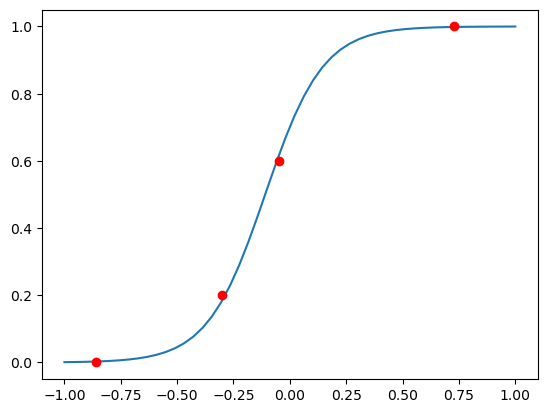

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

logit = lambda x: 1. / (1 + np.exp(-x))
xvals = np.linspace(-1, 1)
plt.plot(xvals, logit(b_value*xvals + a_value))
plt.plot(dose, deaths/5., 'ro')

### Exercise

How do we obtain LD50 (the dose for which there is 50% mortality) from the model?

In [ ]:
# Write your answer here

### Graph manipulation 101

Another interesting feature of PyTensor is the ability to manipulate the computational graph, something that is not possible with TensorFlow or PyTorch. Here we continue with the example above in order to illustrate the main idea around this technique.

In [24]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs=[w]))

[x, y]

As a simple example, let's add an `pytensor.tensor.exp` before the `pytensor.tensor.log` (to get the identity function).

In [25]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

Note that the graph of `w` has actually not changed:

In [26]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


To modify the graph we need to use the `pytensor.clone_replace` function, which *returns a copy of the initial subgraph with the corresponding substitutions.*

In [27]:
new_w = pytensor.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Log [id A] 'log(exp(x + y))'
 └─ Exp [id B] 'exp(x + y)'
    └─ Add [id C] 'x + y'
       ├─ ExpandDims{axis=0} [id D]
       │  └─ x [id E]
       └─ y [id F]


Finally, we can test the modified graph by passing some input to the new graph.

In [28]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

As expected, the new graph is just the identity function.

> NOTE:
> Again, note that `pytensor` is clever enough to omit the `exp` and `log` once we compile the function.

In [29]:
f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Add [id A] 'x + y' 1
 ├─ ExpandDims{axis=0} [id B] 0
 │  └─ x [id C]
 └─ y [id D]


In [30]:
f(x=0, y=[1, np.e])

array([1.        , 2.71828183])

### PyTensor RandomVariables

Now that we have seen pytensor's basics we want to move in the direction of random variables.

How do we generate random numbers in [`numpy`](https://github.com/numpy/numpy)? To illustrate it we can sample from a normal distribution:

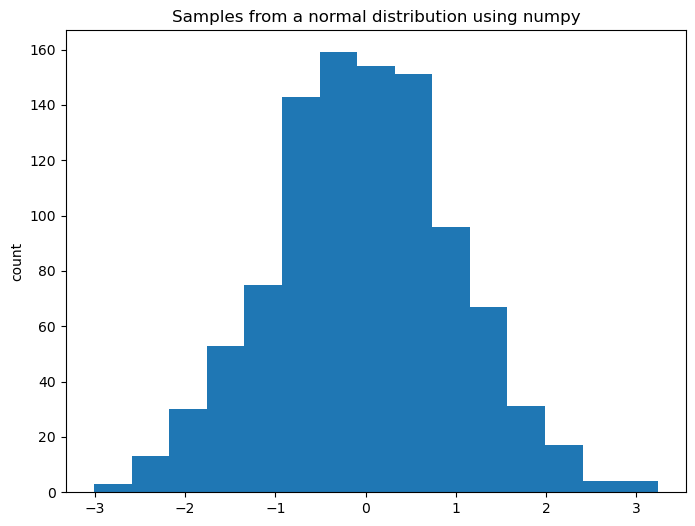

In [31]:
a = np.random.normal(loc=0, scale=1, size=1_000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a, color="C0", bins=15)
ax.set(title="Samples from a normal distribution using numpy", ylabel="count");

Now let's try to do it in PyTensor.

In [32]:
y = pt.random.normal(loc=0, scale=1, name="y")
y.type

TensorType(float64, shape=())

Next, we show the graph using `pytensor.dprint`.

In [33]:
pytensor.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FD50B8F3A00>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ 0 [id E]
 └─ 1 [id F]


The inputs are always in the following order:
1. `rng` shared variable
2. `size`
3. `dtype` (number code)
4. `arg1`, `arg2` ... `argn`

We *could* sample by calling `eval()`. on the random variable.

In [34]:
y.eval()

array(-1.86179423)

Note however that these samples are always the same!

In [35]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: -1.861794228378853
Sample 1: -1.861794228378853
Sample 2: -1.861794228378853
Sample 3: -1.861794228378853
Sample 4: -1.861794228378853
Sample 5: -1.861794228378853
Sample 6: -1.861794228378853
Sample 7: -1.861794228378853
Sample 8: -1.861794228378853
Sample 9: -1.861794228378853


We always get the same samples! This has to do with the random seed step in the graph, i.e. `RandomGeneratorSharedVariable` (we will not go deeper into this subject here). We will show how to generate different samples with `pymc` below.

To do so, we start by defining a `pymc` normal distribution.

In [36]:
x = pm.Normal.dist(mu=0, sigma=1)
pytensor.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FD50B984740>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ 0 [id E]
 └─ 1 [id F]


Observe that `x` is just a normal `RandomVariable` and which is the same as `y` except for the `rng`.

We can try to generate samples by calling `eval()` as above.

In [37]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: 0.5806989992881778
Sample 1: 0.5806989992881778
Sample 2: 0.5806989992881778
Sample 3: 0.5806989992881778
Sample 4: 0.5806989992881778
Sample 5: 0.5806989992881778
Sample 6: 0.5806989992881778
Sample 7: 0.5806989992881778
Sample 8: 0.5806989992881778
Sample 9: 0.5806989992881778


As before we get the same value for all iterations. The correct way to generate random samples is using `pymc.draw`.

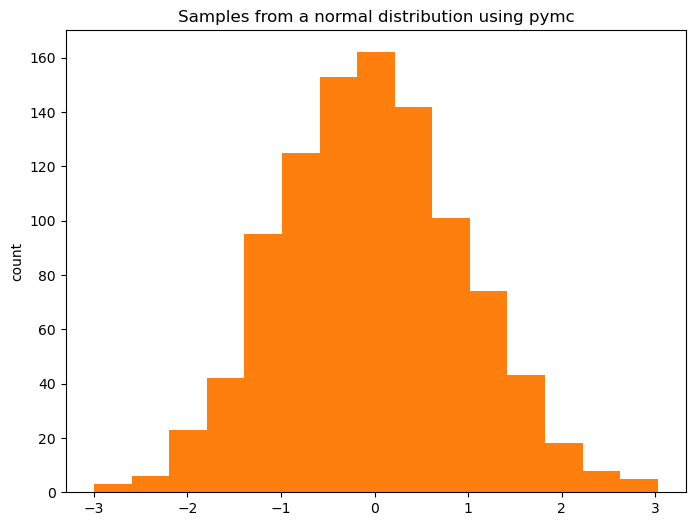

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(pm.draw(x, draws=1_000), color="C1", bins=15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count");

Yay! We learned how to sample from a `pymc` distribution!

### What is going on behind the scenes?

We can now look into how this is done inside a `pymc.Model`.

In [39]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=np.array([0, 0]), sigma=np.array([1, 2]))

pytensor.dprint(z)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FD5037C7BC0>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ [0 0] [id E]
 └─ [1 2] [id F]


We are just creating random variables like we saw before, but now registering them in a `pymc` model. To extract the list of random variables we can simply do:

In [40]:
model.basic_RVs

[z ~ Normal(<constant>, <constant>)]

In [41]:
pytensor.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FD5037C7BC0>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ [0 0] [id E]
 └─ [1 2] [id F]


We can try to sample via `eval()` as above and it is no surprise that we are getting the same samples at each iteration.

In [42]:
for i in range(10):
    print(f"Sample {i}: {z.eval()}")

Sample 0: [-1.56426237 -1.00841209]
Sample 1: [-1.56426237 -1.00841209]
Sample 2: [-1.56426237 -1.00841209]
Sample 3: [-1.56426237 -1.00841209]
Sample 4: [-1.56426237 -1.00841209]
Sample 5: [-1.56426237 -1.00841209]
Sample 6: [-1.56426237 -1.00841209]
Sample 7: [-1.56426237 -1.00841209]
Sample 8: [-1.56426237 -1.00841209]
Sample 9: [-1.56426237 -1.00841209]


Again, the correct way of sampling is via `pymc.draw`. 

In [43]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: [-0.79708044  0.02963011]
Sample 1: [ 0.01243505 -1.31449447]
Sample 2: [-0.06955027  0.71146123]
Sample 3: [-0.02040464  1.85911103]
Sample 4: [-0.61046639 -2.4681048 ]
Sample 5: [-0.40168971  2.15228663]
Sample 6: [-0.14299869  1.70416964]
Sample 7: [ 0.90905609 -2.20994174]
Sample 8: [ 0.60445339 -0.80718181]
Sample 9: [-0.30350106  0.54720149]


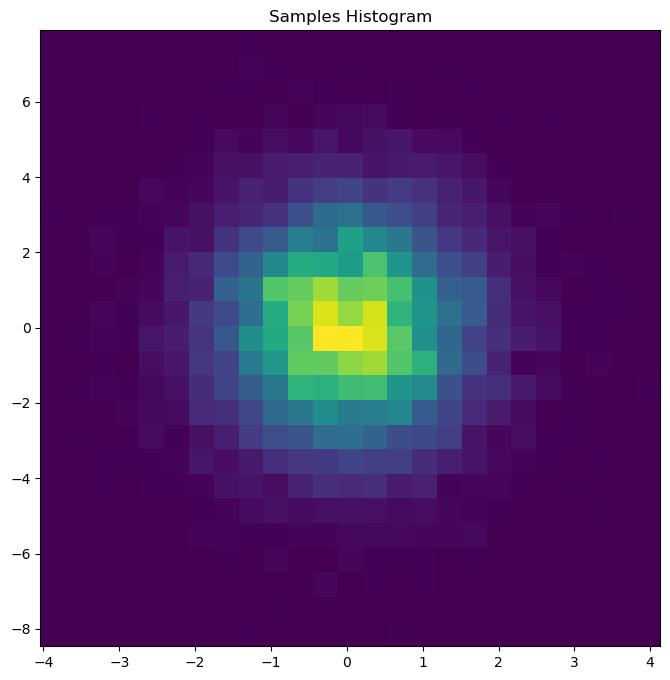

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
z_draws = pm.draw(vars=z, draws=10_000)
ax.hist2d(x=z_draws[:, 0], y=z_draws[:, 1], bins=25)
ax.set(title="Samples Histogram");

### Enough with Random Variables, I want to see some (log)probabilities!

Recall we have defined the following model above:

In [45]:
model

z ~ Normal(<constant>, <constant>)

`pymc` is able to convert `RandomVariable`s to their respective probability functions. One simple way is to use `pymc.logp`, which takes as first input a RandomVariable, and as second input the value at which the logp is evaluated (we will discuss this in more detail later).

In [46]:
z_value = pt.vector(name="z")
z_logp = pm.logp(rv=z, value=z_value)

`z_logp` contains the PyTensor graph that represents the log-probability of the normal random variable `z`, evaluated at `z_value`.

In [47]:
pytensor.dprint(z_logp)

Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ [0 0] [id K]
 │  │  │     │  └─ [1 2] [id L]
 │  │  │     └─ ExpandDims{axis=0} [id M]
 │  │  │        └─ 2 [id N]
 │  │  └─ ExpandDims{axis=0} [id O]
 │  │     └─ Log [id P]
 │  │        └─ Sqrt [id Q]
 │  │           └─ 6.283185307179586 [id R]
 │  └─ Log [id S]
 │     └─ [1 2] [id L]
 └─ All{axes=None} [id T]
    └─ MakeVector{dtype='bool'} [id U]
       └─ All{axes=None} [id V]
          └─ Gt [id W]
             ├─ [1 2] [id L]
             └─ ExpandDims{axis=0} [id X]
                └─ 0 [id Y]


> TIP:
> There is also a handy `pymc` function to compute the log cumulative probability of a random variable `pymc.logcdf`.

Observe that, as explained at the beginning, there has been no computation yet. The actual computation is performed after compiling and passing the input. For illustration purposes alone, we will again use the handy `eval()` method.

In [48]:
z_logp.eval({z_value: [0, 0]})

array([-0.91893853, -1.61208571])

This is nothing other than an evaluation of the log probability of a normal distribution.

In [49]:
scipy.stats.norm.logpdf(x=np.array([0, 0]), loc=np.array([0, 0]), scale=np.array([1, 2]))

array([-0.91893853, -1.61208571])

`pymc` models provide some helpful routines to facilitate the conversion of `RandomVariable`s to probability functions. The model `logp` method, for instance can be used to extract the joint probability of all variables in the model:

In [52]:
pytensor.dprint(model.logp(sum=False))

Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ [0 0] [id K]
 │  │  │     │  └─ [1 2] [id L]
 │  │  │     └─ ExpandDims{axis=0} [id M]
 │  │  │        └─ 2 [id N]
 │  │  └─ ExpandDims{axis=0} [id O]
 │  │     └─ Log [id P]
 │  │        └─ Sqrt [id Q]
 │  │           └─ 6.283185307179586 [id R]
 │  └─ Log [id S]
 │     └─ [1 2] [id L]
 └─ All{axes=None} [id T]
    └─ MakeVector{dtype='bool'} [id U]
       └─ All{axes=None} [id V]
          └─ Gt [id W]
             ├─ [1 2] [id L]
             └─ ExpandDims{axis=0} [id X]
                └─ 0 [id Y]


Because we only have one variable, this function is equivalent to what we obtained by manually calling `pm.logp` before. We can also use a helper method `pymc.Model.compile_logp` to return an already compiled PyTensor function of the model logp.

In [53]:
logp_function = model.compile_logp(sum=False)

This function expects a "point" dictionary as input. We could create it ourselves, but just to illustrate another useful `Model` method, let's call `Model.initial_point`, which returns the point that most samplers use when deciding where to start sampling.

In [54]:
point = model.initial_point()
point

{'z': array([0., 0.])}

In [55]:
logp_function(point)

[array([-0.91893853, -1.61208571])]

### What are value variables and why are they important?

As he have seen above, a logp graph does not have random variables. Instead it is defined in terms of input (value) variables. When we want to sample, each random variable (RV) is replaced by a logp function evaluated at the respective input (value) variable. Let's see how this works through some examples. RV and value variables can be observed in these [`scipy`](https://github.com/scipy/scipy) operations:

In [56]:
rv = scipy.stats.norm(0, 1)

# Equivalent to rv = pm.Normal("rv", 0, 1)
rv

In [57]:
# Equivalent to rv_draw = pm.draw(rv, 3)
rv.rvs(3)

array([-1.71684718, -1.1572584 ,  1.36713684])

In [58]:
# Equivalent to rv_logp = pm.logp(rv, 1.25)
rv.logpdf(1.25)

-1.7001885332046727

Next, let's look at how these value variables behave in a slightly more complex model.

In [59]:
with pm.Model() as model_2:
    mu = pm.Normal(name="mu", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=3)
    x = pm.Normal(name="x", mu=mu, sigma=sigma)

Each model RV is related to a "value variable":

In [60]:
model_2.rvs_to_values

{mu ~ Normal(0, 2): mu,
 sigma ~ HalfNormal(0, 3): sigma_log__,
 x ~ Normal(mu, sigma): x}

Observe that for sigma the associated value is in the *log* scale as in practice we require unbounded values for efficient Markov chain Monte Carlo (MCMC) sampling.

In [61]:
model_2.value_vars

[mu, sigma_log__, x]

Now that we know how to extract the model variables, we can compute the element-wise log-probability of the model for specific values.

In [62]:
# extract values as pytensor.tensor.var.TensorVariable
mu_value = model_2.rvs_to_values[mu]
sigma_log_value = model_2.rvs_to_values[sigma]
x_value = model_2.rvs_to_values[x]
# element-wise log-probability of the model (we do not take te sum)
logp_graph = pt.stack(model_2.logp(sum=False))
# evaluate by passing concrete values
logp_graph.eval({mu_value: 0, sigma_log_value: -10, x_value: 0})

array([ -1.61208572, -11.32440366,   9.08106147])

This equivalent to:

In [63]:
print(
    f"""
mu_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=2)}
sigma_log_value -> {- 10 + scipy.stats.halfnorm.logpdf(x=np.exp(-10), loc=0, scale=3)} 
x_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=np.exp(-10))}
"""
)


mu_value -> -1.612085713764618
sigma_log_value -> -11.324403641427345 
x_value -> 9.081061466795328



> NOTE:
> For `sigma_log_value` we add the $-10$ term for the `scipy` and `pytensor` to match because of the jacobian.

As we already saw, we can also use the method `compile_logp` to obtain a compiled pytensor function of the model logp, which takes a dictionary of `{value variable name : value}` as inputs:

In [64]:
model_2.compile_logp(sum=False)({"mu": 0, "sigma_log__": -10, "x": 0})

[array(-1.61208572), array(-11.32440366), array(9.08106147)]

The `pymc.Model` class also has methods to extract the gradient `dlogp` and the hessian `d2logp` of the logp.

If you want to go deeper into the internals of `pytensor` RandomVariables and `pymc` distributions please take a look into the [distribution developer guide](https://www.pymc.io/projects/docs/en/stable/contributing/implementing_distribution.html).

## Debugging

There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC` uses `PyTensor` expressions to build the model rather than functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the `pytensor.printing.Print` class to print intermediate values.

### How to print intermediate values of `PyTensor` functions
Since `PyTensor` functions are compiled to C (or some other backend), you have to use `pytensor.printing.Print` class to print intermediate values (imported  below as `Print`). Python `print` function will not work. Below is a simple example of using `Print`. 

In [65]:
x = pt.dvector("x")
y = pt.dvector("y")
func = pytensor.function([x, y], 1 / (x - y))
func([1, 2, 3], [1, 0, -1])

array([ inf, 0.5 , 0.25])

To see what causes the `inf` value in the output, we can print intermediate values of $(x-y)$ using `Print`. `Print` class simply passes along its caller but prints out its value along a user-define message:

In [66]:
Print = pytensor.printing.Print

z_with_print = Print("x - y = ")(x - y)
func_with_print = pytensor.function([x, y], 1 / z_with_print)
func_with_print([1, 2, 3], [1, 0, -1])

x - y =  __str__ = [0. 2. 4.]


array([ inf, 0.5 , 0.25])

`Print` reveals the root cause: $(x-y)$ takes a zero value when $x=1, y=1$, causing the `inf` output.

### How to capture `Print` output for further analysis

When we expect many rows of output from `Print`, it can be desirable to redirect the output to a string buffer and access the values later on. Here is a toy example using Python `print` function:

In [67]:
import sys

from io import StringIO

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

for i in range(5):
    print(f"Test values: {i}")

In [68]:
output = mystdout.getvalue().split("\n")
sys.stdout = old_stdout  # setting sys.stdout back
output

['Test values: 0',
 'Test values: 1',
 'Test values: 2',
 'Test values: 3',
 'Test values: 4',
 '']

### Troubleshooting a toy PyMC model

In [69]:
rng = np.random.default_rng(RANDOM_SEED)
x = rng.normal(size=100)

with pm.Model() as model:
    # priors
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.Normal("sd", mu=0, sigma=1)

    # setting out printing for mu and sd
    mu_print = Print("mu")(mu)
    sd_print = Print("sd")(sd)

    # likelihood
    obs = pm.Normal("obs", mu=mu_print, sigma=sd_print, observed=x)

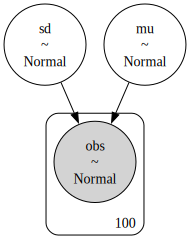

In [70]:
pm.model_to_graphviz(model)

In [71]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5, step=step, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


mu __str__ = 0.0
sd __str__ = 0.0


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu': array(0.), 'sd': array(0.)}

Logp initial evaluation results:
{'mu': -0.92, 'sd': -0.92, 'obs': -inf}
You can call `model.debug()` for more details.

Exception handling of PyMC has improved, so now SamplingError exception prints out the intermediate values of `mu` and `sd` which led to likelihood of `-inf`. However, this technique of printing intermediate values with `pytensor.printing.Print` can be valuable in more complicated cases.

### Bringing it all together

In [72]:
rng = np.random.default_rng(RANDOM_SEED)
y = rng.normal(loc=5, size=20)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    a = pm.Normal("a", mu=0, sigma=10, initval=0.1)
    b = pm.Normal("b", mu=0, sigma=10, initval=0.1)
    sd_print = Print("Delta")(a / b)
    obs = pm.Normal("obs", mu=mu, sigma=sd_print, observed=y)

    # limiting number of samples and chains to simplify output
    trace = pm.sample(draws=10, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

output = mystdout.getvalue()
sys.stdout = old_stdout  # setting sys.stdout back

Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, a, b]


Output()

Delta __str__ = 1.1201748449464126

Delta __str__ = -1.034597937307767

Delta __str__ = 1.1201748449464126

Delta __str__ = -1.0052632266480181

Delta __str__ = 1.1201748449464126

Delta __str__ = -1.045167584246843

Delta __str__ = 1.1201748449464126

Delta __str__ = -1.0000654618321854

Delta __str__ = 1.1201748449464126

Delta __str__ = -1.001563464064823

Delta __str__ = 1.1201748449464126

Delta __str__ = -0.9947811326651326

Delta __str__ = 1.1201748449464126

Delta __str__ = -0.9781621135718288

Delta __str__ = 1.1201748449464126

Delta __str__ = -0.9991517760061399

Delta __str__ = 1.1201748449464126

Delta __str__ = -0.9762379453736406

Delta __str__ = 1.1201748449464126

Delta __str__ = -0.9686864611911746

Sampling 1 chain for 0 tune and 10 draw iterations (0 + 10 draws total) took 0 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


In [73]:
output

'Delta __str__ = 1.1201748449464126\nDelta __str__ = 1.1201748449464126\n'

Raw output is a bit messy and requires some cleanup and formatting to convert to `numpy.ndarray`. In the example below regex is used to clean up the output, and then it is evaluated with `eval` to give a list of floats. Code below also works with higher-dimensional outputs (in case you want to experiment with different models).

In [74]:
import re

# output cleanup and conversion to numpy array
# this is code accepts more complicated inputs
pattern = re.compile("Delta __str__ = ")
output = re.sub(pattern, " ", output)
pattern = re.compile("\\s+")
output = re.sub(pattern, ",", output)
pattern = re.compile(r"\[,")
output = re.sub(pattern, "[", output)
output += "]"
output = "[" + output[1:]
output = eval(output)
output = np.array(output)

In [75]:
output

array([1.12017484, 1.12017484])

Notice that we requested 5 draws, but got 34 sets of $a/b$ values. The reason is that for each iteration, all proposed values are printed (not just the accepted values). Negative values are clearly problematic.

---
## References

[PyTensor: Getting Started](https://pytensor.readthedocs.io/en/latest/introduction.html)

[PyTensor: Implementing a Random Variable Distribution](https://www.pymc.io/projects/docs/en/stable/contributing/implementing_distribution.html)